<a href="https://colab.research.google.com/github/yudam-J/BERT-Cascading-Classifier/blob/main/weightforlevel3onehot(1%2C2%2C1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 기본 모듈
import os
import sys
import json
import re
import urllib.request
from glob import glob
from collections import Counter
import importlib

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt

# Colab
from google.colab import drive

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

# HuggingFace Transformers
from transformers import AutoModel, AutoTokenizer
from torch.optim import AdamW

# 평가 및 지표
from sklearn.metrics import (
    f1_score, roc_auc_score, recall_score,
    accuracy_score, precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# 진행바
from tqdm.auto import tqdm

pd.set_option('display.float_format', '{:.0f}'.format)
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-k61xdum7/kobert-tokenizer_91af0c28d4e64064b68a5608318cf3a4
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-k61xdum7/kobert-tokenizer_91af0c28d4e64064b68a5608318cf3a4
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=aa9b7ebcf39c669e6df718cca613aeb6f433013d14d4ae93ca75138d2f8d9515
  Stored in directory: /tmp/pip-ephem-wheel-cache-9myket2i/wheels/b7/95/7c/3f38b039ae9422cc4a51702b37e352d0585442cbe60285f1f2
Successfully built kobert_tokenizer


In [ ]:
final_df = pd.read_csv('/content/final_df.csv', encoding = 'utf-8')

<ipython-input-3-030e149079be>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv('/content/final_df.csv', encoding = 'utf-8')


In [ ]:
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str).str.strip().str.replace(" ", "", regex=True)
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)

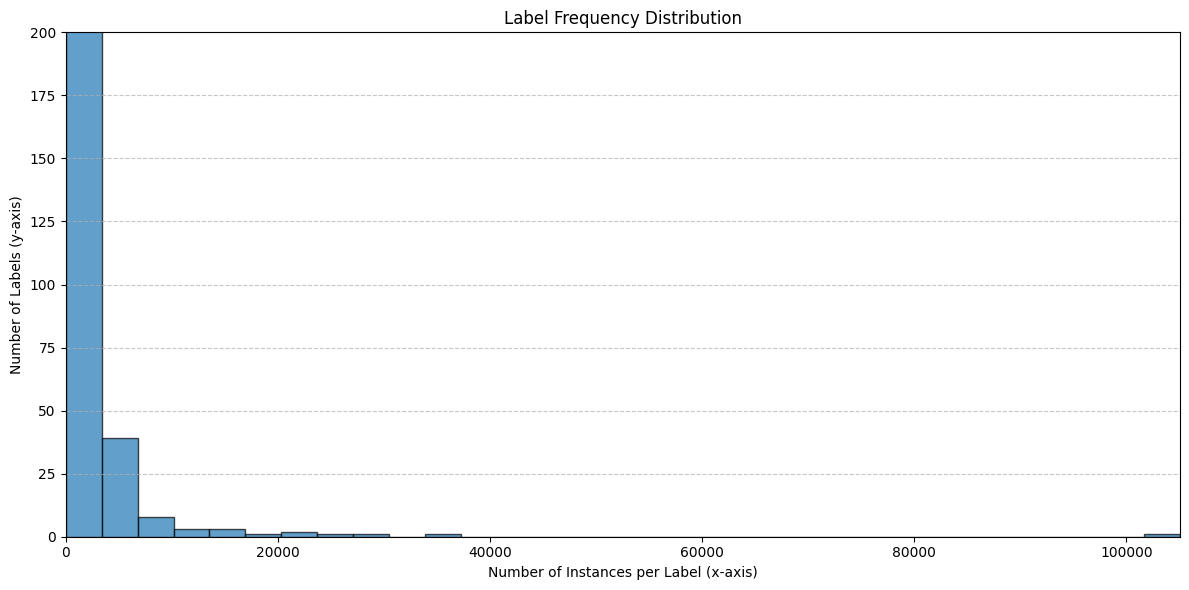

In [ ]:
# 각 라벨의 빈도수 계산
label_counts = Counter(final_df['KDC_NM'])

# 라벨의 빈도수 (x축에 해당)
label_frequencies = list(label_counts.values())

# 적절한 bin 개수 결정 (빈도수의 분포를 기준으로)
n_bins = int(np.sqrt(len(label_frequencies)))  # 빈도수에 대해 제곱근 법칙 적용

# 라벨 빈도수로 히스토그램 구간 설정
plt.figure(figsize=(12, 6))

# 히스토그램 그리기
plt.hist(
    label_frequencies,  # 라벨 빈도수 사용
    bins=n_bins,  # 동적으로 계산된 bin 개수
    edgecolor='black',
    alpha=0.7
)

# x축 최대값을 label_frequencies의 최댓값으로 설정
plt.xlim(0, max(label_frequencies))
plt.ylim(0, 200)

# 그래프 설정
plt.title('Label Frequency Distribution')
plt.xlabel('Number of Instances per Label (x-axis)')
plt.ylabel('Number of Labels (y-axis)')

# x축에 라벨 빈도수 표시, y축에는 레이블 개수 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
# 각 고유 라벨의 개수 세기
label_counts = final_df['KDC_NM'].value_counts()

# 평균, 최대, 최소, 중간값 구하기
mean_count = label_counts.mean()
max_count = label_counts.max()
min_count = label_counts.min()
median_count = label_counts.median()  # 중간값 계산

# 결과 출력
print(f"라벨 개수의 평균: {mean_count}")
print(f"라벨 개수의 최대값: {max_count}")
print(f"라벨 개수의 최소값: {min_count}")
print(f"라벨 개수의 중간값: {median_count}")

라벨 개수의 평균: 917.074
라벨 개수의 최대값: 105047
라벨 개수의 최소값: 1
라벨 개수의 중간값: 83.0


In [ ]:
final_df.shape

(917074, 4)

In [ ]:
final_df.head()

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM,description
0,반 고흐,9788988950050,651,어린이들을 위한 서양미술 입문서 '화가의 마을' 시리즈 3권. 벨기에의 카스테르망(...
1,의사결정 불변의 법칙,9788958610038,325,의사결정에 대한 전략서. 일상생활 속에서 일어나는 다양한 실제 사례를 통해 인간이 ...
2,공주를 키워주는 회사는 없다,9788982736964,325,간단하게 말해서 이 책은 우선 직장에서 살아남고 그 다음에 성공으로 가는 방법을 알...
3,중국의 제4물결,9788947524223,341,"13억 중국을 이끌어갈 후진타오와 4세대 지도자 우방궈 전인대 상무위원장, 완자바오..."
4,"(공병호의)10년 후, 세계",9788973376414,321,"으로 한국사회의 변화의 필요성을 역설하며 큰 반향을 불러일으켰던 공병호 박사, 그는..."


In [ ]:
# 하이퍼파라미터
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH = 202
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
GRAD_ACCUMULATION_STEPS = 4
NUM_EPOCHS = 10
PATIENCE = 3  # early stopping 기준

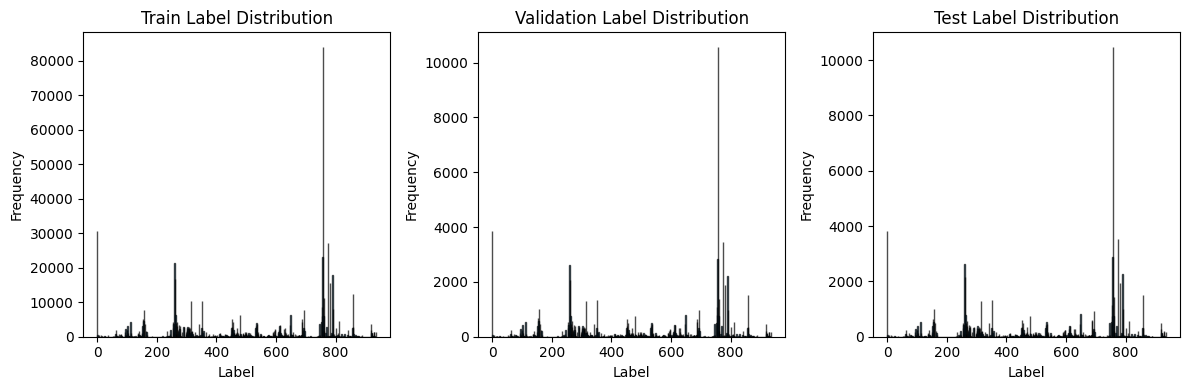

In [ ]:
# 데이터셋 정의
class BookDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, label_dicts):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_dicts = label_dicts

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        input_text = item['TITLE_NM'] + " " + item['description']
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        labels = {
            'level1': self.label_dicts['level1'].get(str(item['level1']), 0),
            'level2': self.label_dicts['level2'].get(str(item['level2']), 0),
            'level3': self.label_dicts['level3'].get(str(item['level3']), 0)
        }

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels
        }


# 모델 정의
class CascadingBERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(CascadingBERTClassifier, self).__init__()
        self.bert = bert_model
        self.fc1 = nn.Linear(self.bert.config.hidden_size, num_classes['level1'])
        self.fc2 = nn.Linear(self.bert.config.hidden_size + num_classes['level1'], num_classes['level2'])
        self.fc3 = nn.Linear(self.bert.config.hidden_size + num_classes['level2'], num_classes['level3'])

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]

        level1_logits = self.fc1(cls_output)
        level1_pred = F.one_hot(level1_logits.argmax(dim=-1), num_classes=level1_logits.shape[-1]).float()

        level2_input = torch.cat([cls_output, level1_pred], dim=-1)
        level2_logits = self.fc2(level2_input)
        level2_pred = F.one_hot(level2_logits.argmax(dim=-1), num_classes=level2_logits.shape[-1]).float()

        level3_input = torch.cat([cls_output, level2_pred], dim=-1)
        level3_logits = self.fc3(level3_input)

        return level1_logits, level2_logits, level3_logits


# KDC 코드 레벨 분해
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)
final_df["level1"] = final_df["KDC_NM"].apply(lambda x: x[:1] + "00" if len(x) >= 1 else "000")
final_df["level2"] = final_df["KDC_NM"].apply(lambda x: x[:2] + "0" if len(x) >= 2 else "000")
final_df["level3"] = final_df["KDC_NM"].apply(lambda x: x if len(x) >= 3 else "000")

# 레이블 딕셔너리 생성
label_dicts = {
    level: {str(k): v for v, k in enumerate(sorted(final_df[level].unique()))}
    for level in ['level1', 'level2', 'level3']
}

# 토크나이저 및 데이터셋 생성
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1")
dataset = BookDataset(final_df, tokenizer, MAX_LENGTH, label_dicts)

# 학습/검증/테스트 분할
indices = list(range(len(dataset)))
train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# 라벨 분포 시각화
def plot_label_distribution(train_labels, val_labels, test_labels):
    plt.figure(figsize=(12, 4))
    for i, (labels, title) in enumerate(zip(
        [train_labels, val_labels, test_labels],
        ['Train Label Distribution', 'Validation Label Distribution', 'Test Label Distribution']
    )):
        plt.subplot(1, 3, i+1)
        plt.hist(labels, bins=np.arange(min(labels), max(labels)+1, 1), edgecolor='black', alpha=0.7)
        plt.title(title)
        plt.xlabel('Label')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

train_labels = [sample['labels']['level3'] for sample in train_dataset]
val_labels = [sample['labels']['level3'] for sample in val_dataset]
test_labels = [sample['labels']['level3'] for sample in test_dataset]
plot_label_distribution(train_labels, val_labels, test_labels)

In [ ]:
# Loss 계산 함수
def compute_loss(outputs, labels, loss_fns, weights=(1.0, 2.0, 1.0)):
    label1 = labels['level1'].to(outputs[0].device)
    label2 = labels['level2'].to(outputs[1].device)
    label3 = labels['level3'].to(outputs[2].device)

    loss1 = loss_fns['level1'](outputs[0], label1)
    loss2 = loss_fns['level2'](outputs[1], label2)
    loss3 = loss_fns['level3'](outputs[2], label3)

    return weights[0] * loss1 + weights[1] * loss2 + weights[2] * loss3

# 클래스 가중치 계산
from collections import Counter

labels = dataset.data['level3'].astype(str).tolist()
label_counts = Counter([dataset.label_dicts['level3'].get(label, 0) for label in labels])

# 클래스 개수 수정
num_classes = len(label_dicts['level3'])
total_samples = sum(label_counts.values())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 가중치 계산 (0.1로 기본값 설정하여 오류 방지)
class_weights = [total_samples / (num_classes * label_counts.get(i, 0.1)) for i in range(num_classes)]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs, patience, loss_weights=(1.0, 2.0, 1.0)):
    scaler = GradScaler()
    model.to(device)
    best_val_loss = float("inf")
    early_stopping_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        corrects = {"level1": 0, "level2": 0, "level3": 0}
        total = 0

        train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for batch in train_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = {k: v.to(device) for k, v in batch['labels'].items()}

            optimizer.zero_grad()

            with autocast():
                outputs = model(input_ids, attention_mask)
                loss = compute_loss(outputs, labels, loss_fn, weights=loss_weights)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            total += input_ids.size(0)

            for i, level in enumerate(corrects.keys()):
                preds = outputs[i].argmax(dim=-1)
                corrects[level] += (preds == labels[level]).sum().item()

            train_tqdm.set_postfix(loss=loss.item())

        train_losses.append(total_loss / len(train_loader))
        train_acc_epoch = {level: corrects[level] / total for level in corrects}
        train_accuracies.append(sum(train_acc_epoch.values()) / 3)

        val_loss, val_acc_epoch = evaluate_model(model, val_loader, loss_fn, device, loss_weights)
        val_losses.append(val_loss)
        val_accuracies.append(sum(val_acc_epoch.values()) / 3)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, " +
              ", ".join([f"{k} Acc: {v:.4f}" for k, v in train_acc_epoch.items()]))
        print(f"Val   Loss: {val_loss:.4f}, " +
              ", ".join([f"{k} Acc: {v:.4f}" for k, v in val_acc_epoch.items()]))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered!")
                break

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)


# 평가 함수
def evaluate_model(model, dataloader, loss_fn, device, loss_weights=(1.0, 1.0, 2.0)):
    model.eval()
    total_loss = 0
    corrects = {"level1": 0, "level2": 0, "level3": 0}
    total = 0
    val_tqdm = tqdm(dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = {k: v.to(device) for k, v in batch['labels'].items()}

            outputs = model(input_ids, attention_mask)
            loss = compute_loss(outputs, labels, loss_fn, weights=loss_weights)
            total_loss += loss.item()
            total += input_ids.size(0)

            for i, level in enumerate(corrects.keys()):
                preds = outputs[i].argmax(dim=-1)
                corrects[level] += (preds == labels[level]).sum().item()

    avg_loss = total_loss / len(dataloader)
    acc_per_level = {k: corrects[k] / total for k in corrects}
    return avg_loss, acc_per_level


# 테스트 평가 함수
def test_model(model, test_loader, device):
    model.eval()
    all_preds = {"level1": [], "level2": [], "level3": []}
    all_labels = {"level1": [], "level2": [], "level3": []}

    test_tqdm = tqdm(test_loader, desc="Testing", leave=False)

    with torch.no_grad():
        for batch in test_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = {k: v.cpu().numpy() for k, v in batch['labels'].items()}

            outputs = model(input_ids, attention_mask)
            preds = {level: outputs[i].argmax(dim=-1).cpu().numpy() for i, level in enumerate(all_preds.keys())}

            for level in all_preds:
                all_preds[level].extend(preds[level])
                all_labels[level].extend(labels[level])

    return evaluate_test_metrics(all_preds, all_labels)


# 테스트 메트릭 출력
def evaluate_test_metrics(all_preds, all_labels):
    metrics = {}
    for level in all_preds:
        metrics[level] = {
            "Accuracy": accuracy_score(all_labels[level], all_preds[level]),
            "Micro F1": f1_score(all_labels[level], all_preds[level], average="micro"),
            "Macro F1": f1_score(all_labels[level], all_preds[level], average="macro"),
            "Micro Precision": precision_score(all_labels[level], all_preds[level], average="micro"),
            "Macro Precision": precision_score(all_labels[level], all_preds[level], average="macro"),
            "Micro Recall": recall_score(all_labels[level], all_preds[level], average="micro"),
            "Macro Recall": recall_score(all_labels[level], all_preds[level], average="macro")
        }

    print("\nTest Performance:")
    for level, results in metrics.items():
        print(f" - {level}:")
        for metric, value in results.items():
            print(f"   {metric}: {value:.4f}")
    return metrics


# 학습 시각화 함수
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", marker="o")
    plt.plot(val_losses, label="Val Loss", marker="o")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc", marker="o")
    plt.plot(val_accs, label="Val Acc", marker="o")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

<ipython-input-13-6f08754b395e>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

<ipython-input-13-6f08754b395e>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 12.4760, level1 Acc: 0.5530, level2 Acc: 0.3861, level3 Acc: 0.1825
Val   Loss: 11.0342, level1 Acc: 0.6139, level2 Acc: 0.4621, level3 Acc: 0.2309


Epoch 2/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 2/10
Train Loss: 10.3756, level1 Acc: 0.6362, level2 Acc: 0.4902, level3 Acc: 0.2494
Val   Loss: 9.8465, level1 Acc: 0.6523, level2 Acc: 0.5165, level3 Acc: 0.2835


Epoch 3/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 3/10
Train Loss: 9.2818, level1 Acc: 0.6722, level2 Acc: 0.5367, level3 Acc: 0.2891
Val   Loss: 9.0990, level1 Acc: 0.6780, level2 Acc: 0.5488, level3 Acc: 0.3054


Epoch 4/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 4/10
Train Loss: 8.4905, level1 Acc: 0.6968, level2 Acc: 0.5683, level3 Acc: 0.3160
Val   Loss: 8.7096, level1 Acc: 0.6896, level2 Acc: 0.5626, level3 Acc: 0.3197


Epoch 5/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 5/10
Train Loss: 7.8271, level1 Acc: 0.7170, level2 Acc: 0.5943, level3 Acc: 0.3382
Val   Loss: 8.5388, level1 Acc: 0.6933, level2 Acc: 0.5724, level3 Acc: 0.3389


Epoch 6/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 6/10
Train Loss: 7.2265, level1 Acc: 0.7347, level2 Acc: 0.6171, level3 Acc: 0.3586
Val   Loss: 8.3290, level1 Acc: 0.7026, level2 Acc: 0.5852, level3 Acc: 0.3509


Epoch 7/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 7/10
Train Loss: 6.6468, level1 Acc: 0.7517, level2 Acc: 0.6394, level3 Acc: 0.3783
Val   Loss: 8.2738, level1 Acc: 0.7079, level2 Acc: 0.5899, level3 Acc: 0.3610


Epoch 8/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 8/10
Train Loss: 6.0914, level1 Acc: 0.7684, level2 Acc: 0.6603, level3 Acc: 0.3972
Val   Loss: 8.2327, level1 Acc: 0.7096, level2 Acc: 0.5941, level3 Acc: 0.3631


Epoch 9/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 9/10
Train Loss: 5.5435, level1 Acc: 0.7847, level2 Acc: 0.6806, level3 Acc: 0.4159
Val   Loss: 8.3376, level1 Acc: 0.7141, level2 Acc: 0.5989, level3 Acc: 0.3753


Epoch 10/10 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

Validating:   0%|          | 0/2866 [00:00<?, ?it/s]


Epoch 10/10
Train Loss: 5.0178, level1 Acc: 0.8005, level2 Acc: 0.7016, level3 Acc: 0.4362
Val   Loss: 8.4035, level1 Acc: 0.7141, level2 Acc: 0.6024, level3 Acc: 0.3781


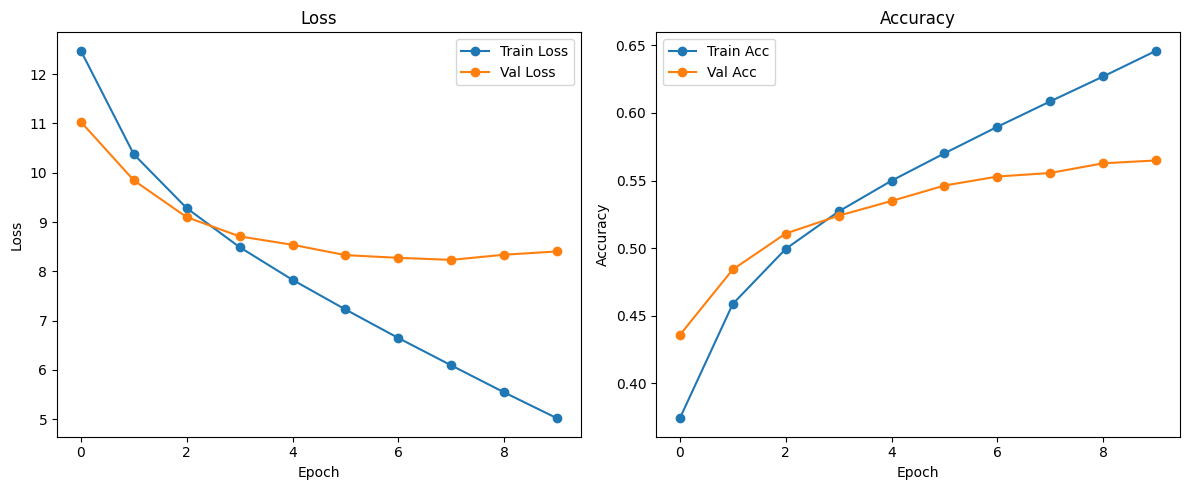

Testing:   0%|          | 0/2866 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Performance:
 - level1:
   Accuracy: 0.7098
   Micro F1: 0.7098
   Macro F1: 0.5699
   Micro Precision: 0.7098
   Macro Precision: 0.5838
   Micro Recall: 0.7098
   Macro Recall: 0.5594
 - level2:
   Accuracy: 0.5934
   Micro F1: 0.5934
   Macro F1: 0.3935
   Micro Precision: 0.5934
   Macro Precision: 0.4495
   Micro Recall: 0.5934
   Macro Recall: 0.3735
 - level3:
   Accuracy: 0.3660
   Micro F1: 0.3660
   Macro F1: 0.1841
   Micro Precision: 0.3660
   Macro Precision: 0.1771
   Micro Recall: 0.3660
   Macro Recall: 0.2548


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
bert_model = AutoModel.from_pretrained("skt/kobert-base-v1")
num_classes = {
    'level1': len(label_dicts['level1']),
    'level2': len(label_dicts['level2']),
    'level3': len(label_dicts['level3']),
}
model = CascadingBERTClassifier(bert_model, num_classes)

loss_fns = {
    "level1": nn.CrossEntropyLoss(),                      # 일반 CrossEntropy
    "level2": nn.CrossEntropyLoss(),                      # 일반 CrossEntropy
    "level3": nn.CrossEntropyLoss(weight=class_weights_tensor)  # 가중치 적용
}

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fns,
    device=DEVICE,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    loss_weights=(1.0, 2.0, 1.0)
)


model.load_state_dict(torch.load("best_model.pt"))
test_metrics = test_model(model, test_loader, device)

In [ ]:
# 1. 체크포인트 불러오기
checkpoint = torch.load("/content/onehot_epoch2.pt", map_location=DEVICE)

# 2. 저장된 정보 추출
label_dicts = checkpoint["label_dicts"]
args = checkpoint["args"]

# 3. 모델 재구성 및 가중치 로드
bert_model = AutoModel.from_pretrained("skt/kobert-base-v1")
model = CascadingBERTClassifier(bert_model, args["num_classes"])
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE)

print("✅ 저장된 모델 불러오기 완료.")

# 4. 옵티마이저 다시 정의 (새로운 학습률 설정 가능)
optimizer = AdamW(model.parameters(), lr=2e-5)

# 5. 추가 학습 시작
NUM_EPOCHS = 8       # 추가 학습 에폭 수
PATIENCE = 2         # 얼리 스톱핑 기준

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fns,
    device=DEVICE,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)

# 6. 가장 성능 좋았던 모델 다시 로드 (early stopping에 의해 저장된 best_model.pt)
model.load_state_dict(torch.load("best_model.pt", map_location=DEVICE))
model.to(DEVICE)
print("\n✅ 테스트 전 최적 모델 로드 완료.")

# 7. 테스트 수행
test_metrics = test_model(model, test_loader, DEVICE)


In [ ]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing for Confusion Matrix"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']['level3'].to(device)

        # autocast는 AMP 환경에서만 사용 (선언 안 되어 있다면 생략 가능)
        # with autocast():
        _, _, logits = model(input_ids, attention_mask)

        preds = torch.argmax(logits, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion Matrix 생성
conf_matrix = confusion_matrix(all_labels, all_preds)

# 클래스 이름 정렬 (level3 기준)
class_names = [k for k, _ in sorted(label_dicts['level3'].items(), key=lambda x: x[1])]

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=90)
plt.title("Confusion Matrix (Level 3)")
plt.tight_layout()
plt.show()

In [ ]:
misclassified_pairs = list(zip(*top_misclassifications))
misclassified_pairs = sorted(
    misclassified_pairs,
    key=lambda pair: error_matrix[pair[0], pair[1]],
    reverse=True
)

for true_class, pred_class in misclassified_pairs:
    count = error_matrix[true_class, pred_class]
    if count > 0:
        print(f"True: {class_names[true_class]}, Predicted: {class_names[pred_class]}, Count: {count}")